####  Setup

In [1]:
import pandas as pd
import os
import math
import json
import matplotlib.pyplot as plt 
corpus_dir = 'corpus/'

In [2]:
corpus_files = os.listdir(corpus_dir) 
corpus_files = [file for file in corpus_files if file.endswith(".csv")]

### Valid Responses Data

Contabilizamos para cada ejecución la cantidad de respuestas válidas por bloque.

Respuestas válidas != Respuestas correctas. Válidas para el tono: ["A", "S"] y para el número: ["J", "K"].

In [3]:
if not os.path.exists("metadata.csv"):
    df = pd.DataFrame(columns=["date", "gender", "hand", "age", "response_amount_block_1", "response_amount_block_2", "response_amount_block_3", "response_amount_block_4", "total_response_amount"])
    for file in corpus_files:
        file_df = pd.read_csv(f"{corpus_dir}/{file}")
        file = file.split(".")[-2]
        date, gender, hand, age = file.split("_")[1:]
        gender = "woman" if gender == "Mujer" else "man"
        hand = "right" if hand == "Derecha" else "left"
        count_block = lambda block_number : sum(file_df['block'] == block_number)
        b1, b2, b3, b4 = count_block(0), count_block(1), count_block(2), count_block(3)
        df.loc[len(df.index)] = [date, gender, hand, int(age), 
                                    b1, b2, 
                                    b3, b4, 
                                    len(file_df)]

    df.to_csv("metadata.csv")
else:
    df = pd.read_csv("metadata.csv")

In [4]:
df.groupby("hand").count()['age']

hand
left      4
right    61
Name: age, dtype: int64

In [5]:
# stats of age
print(df['age'].describe())
# print "age x years +- y years"
print(f"age {df['age'].mean()} years +- {df['age'].std()} years")

count    65.000000
mean     32.400000
std      11.941001
min      15.000000
25%      23.000000
50%      28.000000
75%      37.000000
max      62.000000
Name: age, dtype: float64
age 32.4 years +- 11.941000795578233 years


Text(0.5, 1.0, 'Género')

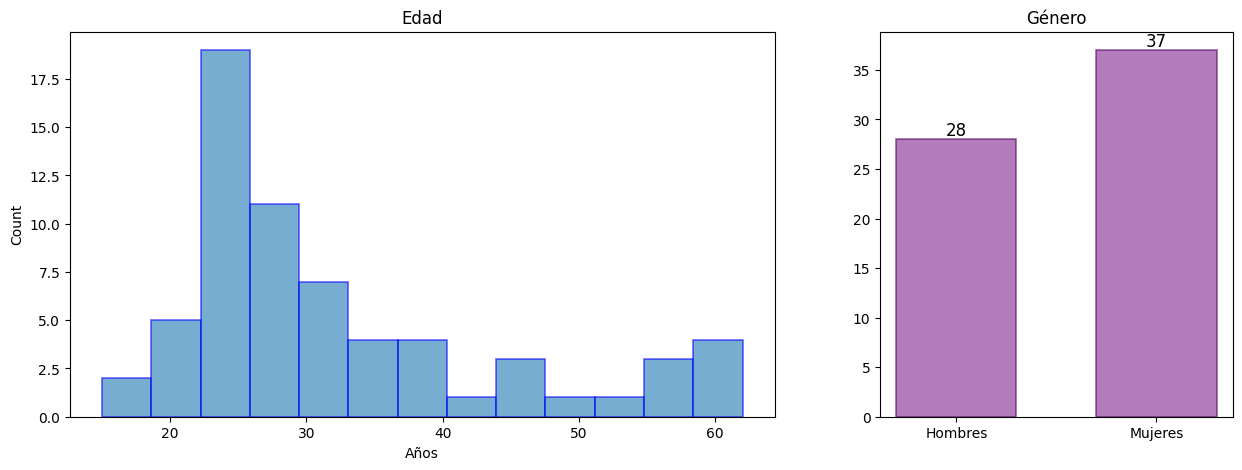

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [2, 1]})

axs[0].hist(df["age"], bins=13, edgecolor="blue", linewidth=1.2, color="#1f77b4", alpha=0.6)
axs[0].set_title("Edad")
axs[0].set_xlabel("Años")
axs[0].set_ylabel("Count")


genders = ["Hombres", "Mujeres"]
counts = df.groupby("gender").count()['age'].values
bars = axs[1].bar(genders, counts, color=["#832491", "#832491"], edgecolor="#51055c", alpha=0.6, linewidth=1.2, width=0.6)

# Adding annotations above each bar
for bar, count in zip(bars, counts):
    height = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width() / 2, height, f'{count}', ha='center', va='bottom', fontsize=12)
axs[1].set_title("Género")


### Figuras del paper

## Figure 2 / Table 2. Effects of the Different Manipulations on the Mean and Dispersion of RT

A. Cambios en el promedio de RT de la tarea de números cuando el delay == 1025 para diferentes manipulaciones experimentales. Cambiar la notación hace al RT mas lento, y dentro de esa condición, las respuestas son mas lentas para distancias cortas que largas. La diferencia ente las condiciones de distancia cercana o lejana es independiente de la manipulación experimental.

B. A different pattern is observed for the interquartile range, which provides a measure of dispersion. While distance manipulation results in a
major change of the interquartile range, there is not a major effect of notation or response complexity.

In [7]:
# get DF (RT_digits_close, RT_digits_far, RT_words_close, RT_words_far) FOR ONLY delay == 1025
indexes = ["name", "RT", "distance", "notation"]

mean_RT_delay_1025 = pd.DataFrame()
name_idx = 0
for file in corpus_files:
    if file.endswith(".csv"):
        file_df = pd.read_csv(f"{corpus_dir}/{file}")
        file_df = file_df[file_df["delay"] == 1025]
        file_df["notation"] = file_df.apply(lambda row: "word" if row.is_word else "digit", axis=1)
        file_df["distance"] = file_df.apply(lambda row: "close" if abs(45 - row.number) <= 12 else "far", axis=1)
        file_df["rt_2_accum"] = file_df.apply(lambda row: row.rt_2+row.delay, axis=1)
        file_df["name"] = name_idx
        mean_RT_delay_1025 = pd.concat([
            mean_RT_delay_1025, pd.concat([
                pd.DataFrame(file_df.groupby(["notation", "distance", "name"]).rt_2.mean()).rename(columns={"rt_2": "rt_2_mean"}),
                pd.DataFrame(file_df.groupby(["notation", "distance", "name"]).rt_2_accum.mean()).rename(columns={"rt_2_accum": "rt_2_accum_mean"}),
                pd.DataFrame(file_df.groupby(["notation", "distance", "name"]).rt_2_accum.apply(lambda x: x.quantile(0.75) - x.quantile(0.25))).rename(columns={"rt_2_accum": "interquartile_range"})], 
                axis=1).reset_index().set_index(["notation", "distance", "name"])

            ], axis=0)
        name_idx += 1
#mean_RT_delay_1025["file"] = corpus_files
mean_RT_delay_1025 = mean_RT_delay_1025.reset_index()

In [8]:
mean_RT_delay_1025

,notation,distance,name,rt_2_mean,rt_2_accum_mean,interquartile_range
0,digit,close,0,629.250000,1654.250000,120.75
1,digit,far,0,669.400000,1694.400000,222.50
2,word,close,0,847.875000,1872.875000,266.75
3,word,far,0,725.750000,1750.750000,145.00
4,digit,close,1,734.900000,1759.900000,70.00
...,...,...,...,...,...,...
199,word,far,49,1404.100000,2429.100000,366.25
200,digit,close,50,577.000000,1602.000000,154.00
201,digit,far,50,503.444444,1528.444444,51.00
202,word,close,50,700.083333,1725.083333,131.25


In [9]:
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm

In [10]:
mean_RT_delay_1025

,notation,distance,name,rt_2_mean,rt_2_accum_mean,interquartile_range
0,digit,close,0,629.250000,1654.250000,120.75
1,digit,far,0,669.400000,1694.400000,222.50
2,word,close,0,847.875000,1872.875000,266.75
3,word,far,0,725.750000,1750.750000,145.00
4,digit,close,1,734.900000,1759.900000,70.00
...,...,...,...,...,...,...
199,word,far,49,1404.100000,2429.100000,366.25
200,digit,close,50,577.000000,1602.000000,154.00
201,digit,far,50,503.444444,1528.444444,51.00
202,word,close,50,700.083333,1725.083333,131.25


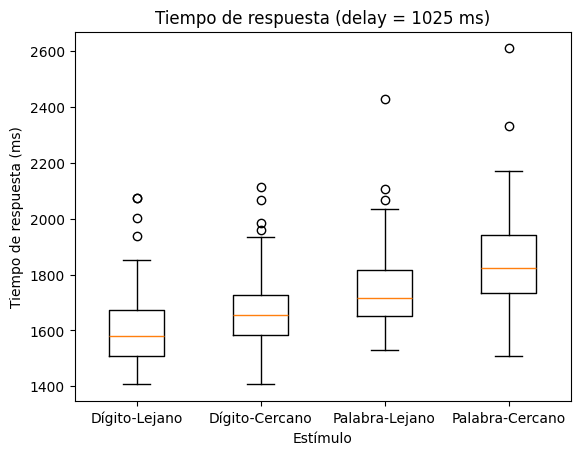

In [11]:
# plot a single figure with 4 bosplots (rt digit_close, rt digit_far, rt word_close, rt word_far)
filter_notation_distance = lambda n, d: mean_RT_delay_1025.loc[(mean_RT_delay_1025["notation"] == n) & (mean_RT_delay_1025["distance"] == d)]["rt_2_accum_mean"].values

digits_far = filter_notation_distance("digit", "far")
digits_close = filter_notation_distance("digit", "close")
words_far = filter_notation_distance("word", "far")
words_close = filter_notation_distance("word", "close")

plt.boxplot([digits_far, digits_close, words_far, words_close], labels=["Dígito-Lejano", "Dígito-Cercano", "Palabra-Lejano", "Palabra-Cercano"])
plt.title("Tiempo de respuesta (delay = 1025 ms)")
plt.ylabel("Tiempo de respuesta (ms)")
plt.xlabel("Estímulo")
plt.show()


In [12]:
mean_RT_delay_1025[10:30]


,notation,distance,name,rt_2_mean,rt_2_accum_mean,interquartile_range
10,word,close,2,629.454545,1654.454545,130.00
11,word,far,2,625.375000,1650.375000,197.25
12,digit,close,3,566.700000,1591.700000,177.75
13,digit,far,3,537.666667,1562.666667,192.00
14,word,close,3,676.875000,1701.875000,137.75
15,word,far,3,599.727273,1624.727273,89.00
16,digit,close,4,579.625000,1604.625000,109.00
17,digit,far,4,432.500000,1457.500000,65.25
18,word,close,4,593.222222,1618.222222,71.00
19,word,far,4,537.818182,1562.818182,100.50


In [13]:
anova_tableRM = anova_lm(ols("rt_2_mean ~ C(notation) * C(distance, Treatment('far')) + C(name)", mean_RT_delay_1025).fit(), typ=2)
anova_tableRM

,sum_sq,df,F,PR(>F)
C(notation),1.314403e+06,1.0,188.705371,2.559382e-28
"C(distance, Treatment('far'))",2.887328e+05,1.0,41.452618,1.541269e-09
C(name),4.559316e+06,50.0,13.091384,8.998486e-35
"C(notation):C(distance, Treatment('far'))",1.664824e+04,1.0,2.390144,1.242095e-01
Residual,1.044805e+06,150.0,NaN,NaN


In [14]:
anova_tableRM2 = anova_lm(ols("interquartile_range ~ C(notation) * C(distance, Treatment('far')) + C(name)", mean_RT_delay_1025).fit(), typ=2)
anova_tableRM2

,sum_sq,df,F,PR(>F)
C(notation),4.860111e+04,1.0,4.242873,0.041144
"C(distance, Treatment('far'))",1.113819e+05,1.0,9.723629,0.002181
C(name),1.204951e+06,50.0,2.103843,0.000305
"C(notation):C(distance, Treatment('far'))",1.028861e+04,1.0,0.898195,0.344791
Residual,1.718215e+06,150.0,NaN,NaN


In [ ]:
results = pd.DataFrame(columns=["Task Manipulation", "Effect", "Mean", "Interquartile Range"])
results.loc[len(results.index)] = [ "Effect of notation", 
                                    "Main effect", 
                                    f"F={anova_table1.loc['C(notation)', 'F']}, p={anova_table1.loc['C(notation)', 'PR(>F)']}", 
                                    f"F={anova_table3.loc['C(notation)', 'F']}, p={anova_table3.loc['C(notation)', 'PR(>F)']}"]
results.loc[len(results.index)] = [ "Effect of notation", 
                                    "Main effect of distance", 
                                    f"F={anova_table1.loc['distance', 'F']}, p={anova_table1.loc['distance', 'PR(>F)']}",
                                    f"F={anova_table3.loc['distance', 'F']}, p={anova_table3.loc['distance', 'PR(>F)']}"]
results.loc[len(results.index)] = [ "Effect of notation", 
                                    "Interaction", 
                                    f"F={anova_table2.loc['notation_distance', 'F']}, p={anova_table2.loc['notation_distance', 'PR(>F)']}",
                                    f"F={anova_table4.loc['notation_distance', 'F']}, p={anova_table4.loc['notation_distance', 'PR(>F)']}"]

results


,Task Manipulation,Effect,Mean,Interquartile Range
0,Effect of notation,Main effect,"F=47.00333436162546, p=8.52068318685329e-11","F=3.3301429274855314, p=0.06950538504052996"
1,Effect of notation,Main effect of distance,"F=10.325149942741593, p=0.0015286244684478442","F=7.631875253289698, p=0.006266589768766271"
2,Effect of notation,Interaction,"F=19.268956605720945, p=5.131318083601494e-11","F=3.883269244311608, p=0.009970523393495504"


/Users/aoppenheim/Desktop/neuro/tps/INCC-parsing_a_cognitive_task/.venv/lib/python3.9/site-packages/statsmodels/graphics/factorplots.py:113: FutureWarning: The provided callable <function mean at 0x10a91aaf0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  plot_data = data.groupby(['trace', 'x']).aggregate(func).reset_index()
/Users/aoppenheim/Desktop/neuro/tps/INCC-parsing_a_cognitive_task/.venv/lib/python3.9/site-packages/statsmodels/graphics/factorplots.py:113: FutureWarning: The provided callable <function mean at 0x10a91aaf0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  plot_data = data.groupby(['trace', 'x']).aggregate(func).reset_index()


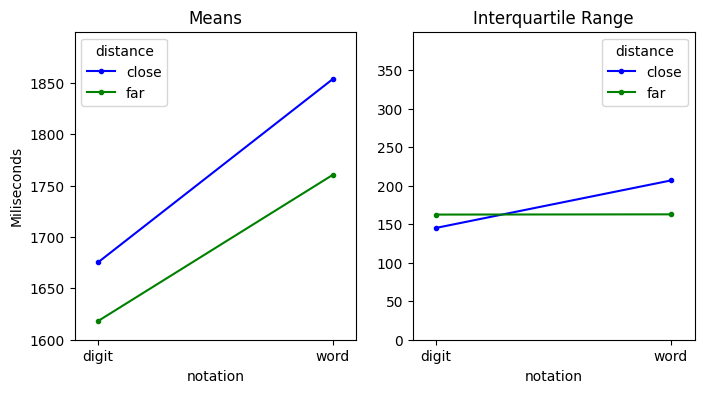

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].set_ylim([1600, 1900])
ax[0].set_yticks(range(1600, 1900, 50))

ax[1].set_ylim([0, 400])
ax[1].set_yticks(range(0, 400, 50))

ax[0].set_xticks(range(2))
ax[0].set_xticklabels(['Digits', 'Words'])
ax[1].set_xticks(range(2))
ax[1].set_xticklabels(['Digits', 'Words'])

ax[0].set_title('Means')
ax[1].set_title('Interquartile Range')

# y axis label

# interaction plot for mean
interaction_plot(mean_RT_delay_1025["notation"], mean_RT_delay_1025["distance"], mean_RT_delay_1025["rt_2_accum_mean"], ax=ax[0], colors=['blue', 'green'])

# interaction plot for interquartile range
# calculate interquartile range for each group
interquartile_range = mean_RT_delay_1025.groupby(["notation", "distance"]).rt_2_accum_mean.apply(lambda x: x.quantile(0.75) - x.quantile(0.25)).to_frame()
interquartile_range = interquartile_range.reset_index()
interquartile_range.columns = ["notation", "distance", "interquartile_range"]
interaction_plot(interquartile_range["notation"], interquartile_range["distance"], interquartile_range["interquartile_range"], ax=ax[1], colors=['blue', 'green'])


ax[0].set_ylabel('Miliseconds')
ax[1].set_ylabel('')



plt.show()


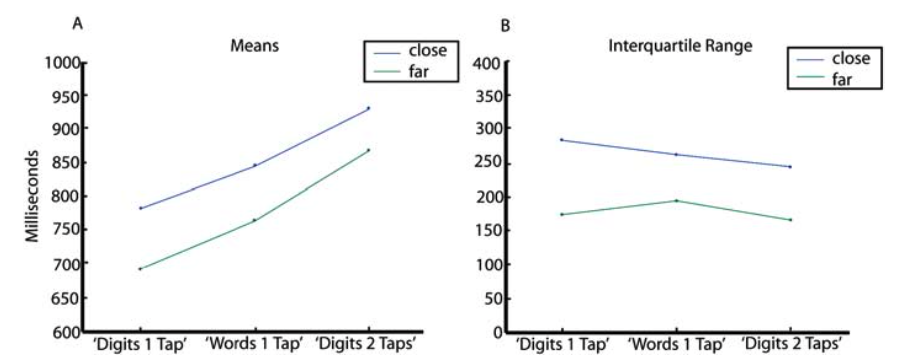

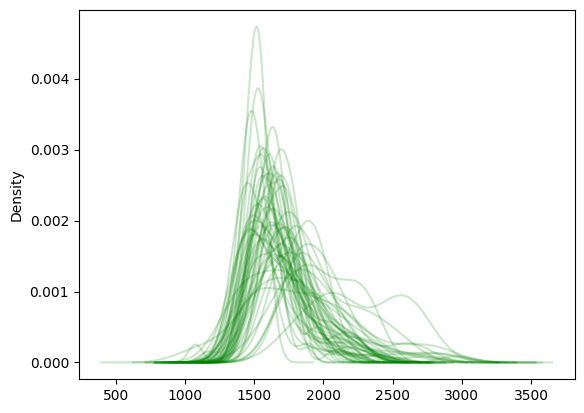

In [17]:
# plotear hist acumulado de todos los sujetos y ver que onda el ruido
from matplotlib import pyplot

#bins = numpy.linspace(-10, 10, 100)
for file in corpus_files:
    if file.endswith(".csv"):
        file_df = pd.read_csv(f"{corpus_dir}/{file}")
        file_df = file_df[file_df["delay"] == 1025]
        file_df["rt_2_accum"] = file_df.apply(lambda row: row.rt_2+row.delay, axis=1)
        file_df.rt_2_accum.plot.density(color='green',alpha=0.2)
pyplot.show()   

In [18]:
mean_notation_RTs = pd.DataFrame()
mean_distance_RTs = pd.DataFrame()
for file in corpus_files:
    if file.endswith(".csv"):
        file_df = pd.read_csv(f"{corpus_dir}/{file}")
        file_df["notation"] = file_df.apply(lambda row: "word" if row.is_word else "digit", axis=1)
        file_df["distance"] = file_df.apply(lambda row: "close" if abs(45 - row.number) <= 12 else "far", axis=1)
        file_df["rt_2_accum"] = file_df.apply(lambda row: row.rt_2+row.delay, axis=1)
        # notation
        rt1_df = pd.DataFrame(file_df.groupby(["notation", "delay"]).rt_1.mean())
        # rt2 in reality is delay + rt2
        rt2_df = pd.DataFrame(file_df.groupby(["notation", "delay"]).rt_2_accum.mean())
        mean_notation_RTs = pd.concat([mean_notation_RTs, pd.concat([rt1_df, rt2_df], axis=1)], axis=0)
        # distance
        rt1_df = pd.DataFrame(file_df.groupby(["distance", "delay"]).rt_1.mean())
        rt2_df = pd.DataFrame(file_df.groupby(["distance", "delay"]).rt_2_accum.mean())
        mean_distance_RTs = pd.concat([mean_distance_RTs, pd.concat([rt1_df, rt2_df], axis=1)], axis=0)

mean_notation_RTs = mean_notation_RTs.reset_index()
mean_distance_RTs = mean_distance_RTs.reset_index()

In [19]:
mean_notation_RTs

,notation,delay,rt_1,rt_2_accum
0,digit,0.0,975.933333,1320.133333
1,digit,102.5,790.875000,1101.687500
2,digit,992.5,763.425000,1621.289474
3,digit,1025.0,752.555556,1676.555556
4,word,0.0,836.500000,1318.625000
...,...,...,...,...
403,digit,1025.0,672.800000,1568.900000
404,word,0.0,746.800000,1075.277778
405,word,102.5,637.300000,1050.150000
406,word,992.5,547.500000,1725.250000


In [20]:
mean_notation_RTs.groupby(["notation", "delay"]).rt_1.mean()

notation  delay 
digit     0.0       843.882554
          102.5     867.537111
          992.5     864.638637
          1025.0    848.928467
word      0.0       888.396324
          102.5     905.499449
          992.5     888.608425
          1025.0    891.167251
Name: rt_1, dtype: float64

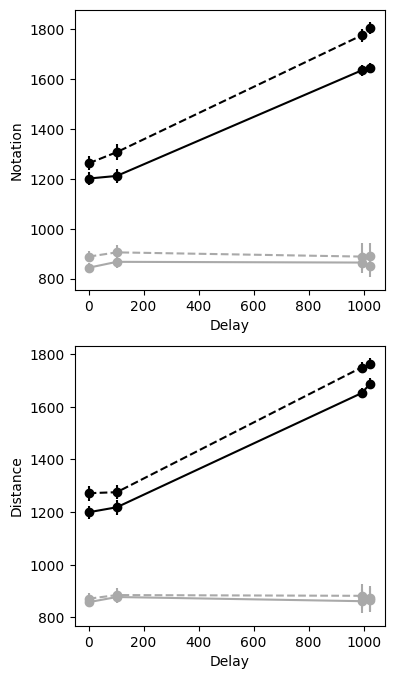

In [21]:
# show a figure with two subplots
# subplot 1: Scatter plot with mean RTs for each delay (x axis) and notation (color) 
# subplot 2: Scatter plot with mean RTs for each delay (x axis) and distance (color)

fig, ax = plt.subplots(2, 1, figsize=(4, 8))

# add scatter plot with lines for mean_notation_RTs with notation as color and line properties
for notation in ["digit", "word"]:
    rt_1_mean = mean_notation_RTs.groupby(["notation", "delay"]).rt_1.mean().reset_index()
    # rt_1_std = mean_notation_RTs.groupby(["notation", "delay"]).rt_1.std().reset_index()
    rt_1_standard_error = mean_notation_RTs.groupby(["notation", "delay"]).rt_1.apply(lambda x: x.std() / math.sqrt(len(x))).reset_index()

    rt_2_accum_mean = mean_notation_RTs.groupby(["notation", "delay"]).rt_2_accum.mean().reset_index()
    # rt_2_accum_std = mean_notation_RTs.groupby(["notation", "delay"]).rt_2_accum.std().reset_index()
    rt_2_accum_standard_error = mean_notation_RTs.groupby(["notation", "delay"]).rt_2_accum.apply(lambda x: x.std() / math.sqrt(len(x))).reset_index()

    # scatter with error bars
    fmt_line = 'o-' if notation == "digit" else 'o--'
    
    ax[0].errorbar( rt_1_mean[rt_1_mean["notation"] == notation]["delay"], 
                    rt_1_mean[rt_1_mean["notation"] == notation]["rt_1"], 
                    yerr=rt_1_standard_error[rt_1_standard_error["notation"] == notation]["rt_1"], 
                    fmt=fmt_line, label=notation, color="darkgray")

    ax[0].errorbar( rt_2_accum_mean[rt_2_accum_mean["notation"] == notation]["delay"],
                    rt_2_accum_mean[rt_2_accum_mean["notation"] == notation]["rt_2_accum"], 
                    yerr=rt_2_accum_standard_error[rt_2_accum_standard_error["notation"] == notation]["rt_2_accum"], 
                    fmt=fmt_line, label=notation, color="black")

for distance in ["close", "far"]:
    rt_1_mean = mean_distance_RTs.groupby(["distance", "delay"]).rt_1.mean().reset_index()
    # rt_1_std = mean_distance_RTs.groupby(["distance", "delay"]).rt_1.std().reset_index() # TODO: cambiar por error estandar
    rt_1_standard_error = mean_distance_RTs.groupby(["distance", "delay"]).rt_1.apply(lambda x: x.std() / math.sqrt(len(x))).reset_index()

    rt_2_accum_mean = mean_distance_RTs.groupby(["distance", "delay"]).rt_2_accum.mean().reset_index()
    # rt_2_accum_std = mean_distance_RTs.groupby(["distance", "delay"]).rt_2_accum.std().reset_index()
    rt_2_accum_standard_error = mean_distance_RTs.groupby(["distance", "delay"]).rt_2_accum.apply(lambda x: x.std() / math.sqrt(len(x))).reset_index()

    # scatter with error bars
    fmt_line = 'o-' if distance == "far" else 'o--'
    
    ax[1].errorbar( rt_1_mean[rt_1_mean["distance"] == distance]["delay"], 
                    rt_1_mean[rt_1_mean["distance"] == distance]["rt_1"], 
                    yerr=rt_1_standard_error[rt_1_standard_error["distance"] == distance]["rt_1"], 
                    fmt=fmt_line, label=distance, color="darkgray")

    ax[1].errorbar( rt_2_accum_mean[rt_2_accum_mean["distance"] == distance]["delay"],
                    rt_2_accum_mean[rt_2_accum_mean["distance"] == distance]["rt_2_accum"], 
                    yerr=rt_2_accum_standard_error[rt_2_accum_standard_error["distance"] == distance]["rt_2_accum"], 
                    fmt=fmt_line, label=distance, color="black")
    

# ax[0].set_title('Notation') on the left

ax[0].set_ylabel('Notation')
ax[0].set_xlabel('Delay')

# ax[1].set_title('Distance')
ax[1].set_ylabel('Distance')
ax[1].set_xlabel('Delay')

plt.show()

# Cambiar std por error estandar /sqrt(n)


In [22]:
rt_2_accum_standard_error

,distance,delay,rt_2_accum
0,close,0.0,28.993556
1,close,102.5,27.636408
2,close,992.5,22.692445
3,close,1025.0,20.953443
4,far,0.0,24.824336
5,far,102.5,27.802699
6,far,992.5,19.465795
7,far,1025.0,21.835970


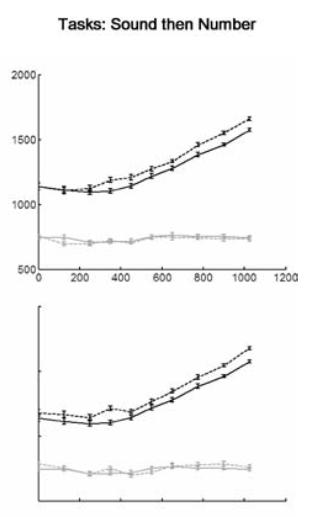

##  Figure 5

Thus, our purpose was to test the prediction of our model that the notation and response-complexity manipulations should affect the parameter $t_0$ while the distance manipulation should affect the parameter $\alpha$.

In [153]:
import numpy as np
def selected(y, values):
    indexes = []
    for value in values:
        # print(np.where(y == value))
        indexes.append(np.where(y == value)[0][0])
    return indexes

In [199]:
def figure_5(subject):
    subject_file = corpus_files[subject]
    assert subject_file.endswith(".csv")

    file_df = pd.read_csv(f"{corpus_dir}/{subject_file}")
    file_df["rt_2_accum"] = file_df.apply(lambda row: row.rt_2 + row.delay, axis=1)
    file_df = file_df[file_df["rt_2_accum"].notna()]
    delays = [0, 102.5, 992.5, 1025.0]
    
    delays_attr = {is_word: {
        d: np.histogram(file_df[(file_df["delay"] == d) & (file_df['is_word'] == is_word)]["rt_2_accum"], bins=1000, density=True)
        for d in delays
    } for is_word in [True, False]}
    
    delays_attr_cumulative = {is_word: {
        d: (bins, np.cumsum(n) / np.sum(n))  # Calculate cumulative distribution
        for d, (n, bins) in delays_attr[is_word].items()
    } for is_word in [True, False]}

    # create figure with two subplots (one for each notation)
    fig, ax = plt.subplots(2, 1, figsize=(5, 10))
    for ax_idx, is_word in enumerate([False, True]):
        for d, (bins_mean, n) in delays_attr_cumulative[is_word].items():
            firsts = selected(n, set(n))
            ax[ax_idx].scatter([bins_mean[i] for i in firsts], [n[i] for i in firsts], s=5, label=d)
            # ax[0 if is_word else 1].plot(bins[:-1], cumulative_n, label=f"{d} ms")
        ax[ax_idx].legend()
        ax[ax_idx].set_xlabel("")
        ax[ax_idx].set_ylabel(f"{'Word' if is_word else 'Digit'}")

    ax[0].set_title(f"Sound then Number")
    ax[1].set_title(f"")

    plt.show()
    # save figure
    # fig.savefig(f"figures/figure_5_subject_{subject}.png")
    
    

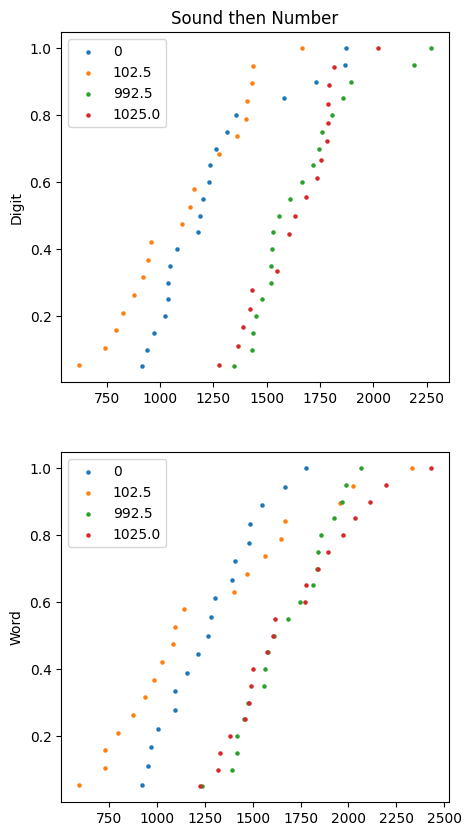

In [200]:
figure_5(23)

t_0, \alpha, \sigma, T 

Parameters of the mathematical model used to fit the distributions of RTs to the first task. The model we use is a simple variant of a general class of models known as random-walk models. Briefly, the model supposes a fixed delay (t_0) followed by a stochastic ac- cumulation of evidence with a fixed drift rate (\alpha) and added Gaussian noise (whose amplitude is determined by the "diffusion constant" \sigma), which stops once it hits a threshold level (T).

In [ ]:
from scipy.stats import invgauss

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.invgauss.html